In [ ]:
!pip install datasets
!pip install evaluate
!pip install fsspec==2023.9.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2023.9.2 which is incompatible.



⚙️ **Requerimientos importantes sobre el ejercicio**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.



## Imports

In [ ]:
import os , random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Reproducibilidad
seed = 42
random.seed(seed)
np.random.seed(seed)

import torch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 🔍 Ejercicio1: Detección de profesiones en tweets

## Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

📝 **Criterios de Evaluación**

Tu trabajo será evaluado según los siguientes criterios:

| Criterio                                            | Peso  |
|-----------------------------------------------------|--------|
| 🔍 Análisis exploratorio y preprocesamiento         | 20%   |
| 🤖 Selección y justificación del modelo             | 25%   |
| 📁 Formato y validez del archivo de predicciones    | 5%    |
| ⚙️ Ejecución correcta del notebook (sin intervención) | 10%   |
| 📈 Rendimiento del modelo sobre el conjunto de test | 30%   |
| ✍️ Claridad y calidad de las explicaciones          | 10%   |



🔔 **Nota importante:**

> El rendimiento del modelo se evaluará utilizando métricas estándar como el **F1-score** sobre el conjunto de test.

> El archivo de predicciones debe respetar **estrictamente** el formato solicitado (`id` y `label`, separados por tabulador y con extensión `.tsv`).  
  ❗ Si el archivo no cumple con este formato, **el ejercicio no podrá ser evaluado en esa sección**.

> El/la estudiante con el **mayor F1-score** obtendrá la puntuación máxima en el apartado de rendimiento. El resto de calificaciones se ajustarán de forma proporcional al mejor resultado



⚙️ **Requerimientos y reglas**

- El notebook debe ejecutarse **de principio a fin sin intervención manual**.
- Si utilizas librerías que no están incluidas por defecto en Google Colab, **asegúrate de instalarlas dentro del notebook** (por ejemplo: `!pip install ...`).

- Algunas celdas incluyen identificadores especiales que indican ciertas normas que **debes** respetar:
 - `#NO-MODIFY: DATA LOAD`  
    🔒 **No modifiques** el contenido de esta celda.

  - `#NO-MODIFY: VARIABLE NAME`  
    ✏️ Puedes modificar o añadir información **dentro de la celda**, pero **sin cambiar el nombre de la variable asignada**. No incluyas más variables de las existentes en la celda.

  - `#MODIFY: ADD INFO TO SOLVE FUNCTION`  
    🔧 Puedes modificar el **interior de la función** para resolver la tarea, pero **no cambies su nombre, la cabecera ni el `return`**.


# Tu resolución (rellena las celdas marcadas)

## Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [ ]:
#NO-MODIFY: DATA LOAD
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/480k [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/162k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/166k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2786 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1001 [00:00<?, ? examples/s]

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [ ]:
#NO-MODIFY: DATA LOAD
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

**Número de documentos**

Obten con la función `get_num_docs_evaluation()` el número de documentos del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def get_num_docs_evaluation(dataset_df):
  # Modifica la función.
    """
    Devuelve el número de documentos (filas) en el dataframe entregado.
    """
    num_docs = int(len(dataset_df))
  # No modifiques el return
    return num_docs


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [ ]:
# Aplica la función
# Uso explícito de las funciones para train y validation
train_num_docs = get_num_docs_evaluation(dataset_train_df)
val_num_docs = get_num_docs_evaluation(dataset_val_df)
print(train_num_docs)
print(val_num_docs)

2786
999


**Número de documentos duplicados**

Obten con la función `detect_duplicates_evaluation()` el número de documentos duplicados del dataset de training y validation.

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def detect_duplicates_evaluation(dataset_df):

  # Modifica la función.
  if 'text' in dataset_df.columns:
    normalized = (
      dataset_df['text']
      .astype(str)
      .str.lower()
      .str.strip()
      .str.replace(r"\s+", " ", regex=True)
        )
    num_duplicates = int(normalized.duplicated().sum())
  else:
    num_duplicates = 0

  # No modifiques el return
  return num_duplicates


Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [ ]:
# Aplica la función
train_num_duplicates = detect_duplicates_evaluation(dataset_train_df)
val_num_duplicates = detect_duplicates_evaluation(dataset_val_df)
print(train_num_duplicates)
print(val_num_duplicates)

0
0


**Número de documentos por cada clase:**


Obten con la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

> Recuerda incorporar la información para el cálculo dentro del a siguiente celda, sin modificar los atributos de entrada ni de salida de la función, ni su nombre.

In [ ]:
#MODIFY: ADD INFO TO SOLVE FUNCTION
def analyse_num_labels_evaluation(dataset_df):
  # Modifica la función.
  if 'label' in dataset_df.columns:
    num_positives = int((dataset_df['label'] == 1).sum())
    num_negatives = int((dataset_df['label'] == 0).sum())
  else:
    num_positives = 0
    num_negatives = 0
  # No modifiques el return
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [ ]:
# Uso explícito de las funciones para train y validation
train_num_docs = get_num_docs_evaluation(dataset_train_df)
val_num_docs   = get_num_docs_evaluation(dataset_val_df)

train_num_duplicates = detect_duplicates_evaluation(dataset_train_df)
val_num_duplicates   = detect_duplicates_evaluation(dataset_val_df)

train_pos, train_neg = analyse_num_labels_evaluation(dataset_train_df)
val_pos, val_neg     = analyse_num_labels_evaluation(dataset_val_df)

print("=== Resumen (usando las funciones) ===")
print(f"Train: num_docs={train_num_docs}, duplicates={train_num_duplicates}, positives={train_pos}, negatives={train_neg}")
print(f"Val:   num_docs={val_num_docs}, duplicates={val_num_duplicates}, positives={val_pos}, negatives={val_neg}")

# Guardar resumen por si lo necesitas
summary_df = pd.DataFrame([
    {"split":"train", "num_docs":train_num_docs, "num_duplicates":train_num_duplicates, "num_positives":train_pos, "num_negatives":train_neg},
    {"split":"validation", "num_docs":val_num_docs, "num_duplicates":val_num_duplicates, "num_positives":val_pos, "num_negatives":val_neg}
])
display(summary_df)
summary_df.to_csv("DEL_RINCON_LAGARDE_LUIS_eda_summary.csv", index=False)

=== Resumen (usando las funciones) ===
Train: num_docs=2786, duplicates=0, positives=1393, negatives=1393
Val:   num_docs=999, duplicates=0, positives=238, negatives=761


,split,num_docs,num_duplicates,num_positives,num_negatives
0,train,2786,0,1393,1393
1,validation,999,0,238,761


**Distribución de la longitud de los tweet en caracteres:**

Longitud media (train): 215.05743000717874
Longitud media (val): 198.39139139139138


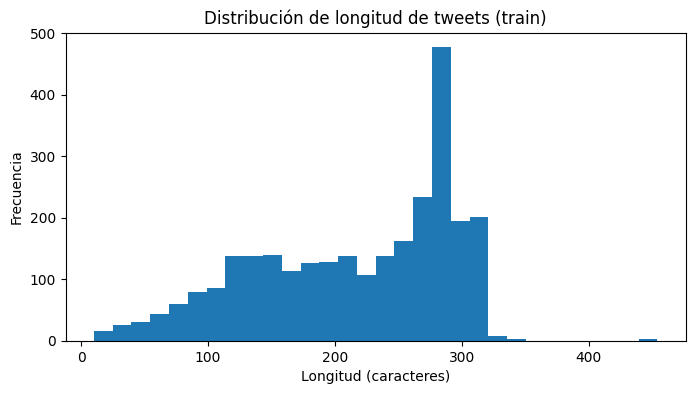

In [ ]:
dataset_train_df['length_chars'] = dataset_train_df['text'].astype(str).map(len)
dataset_val_df['length_chars']   = dataset_val_df['text'].astype(str).map(len)

print("Longitud media (train):", dataset_train_df['length_chars'].mean())
print("Longitud media (val):", dataset_val_df['length_chars'].mean())

plt.figure(figsize=(8,4))
plt.hist(dataset_train_df['length_chars'], bins=30)
plt.title("Distribución de longitud de tweets (train)")
plt.xlabel("Longitud (caracteres)")
plt.ylabel("Frecuencia")
plt.show()

**Análisis de contenido de los tweets**

Para ello utiliza wordclouds

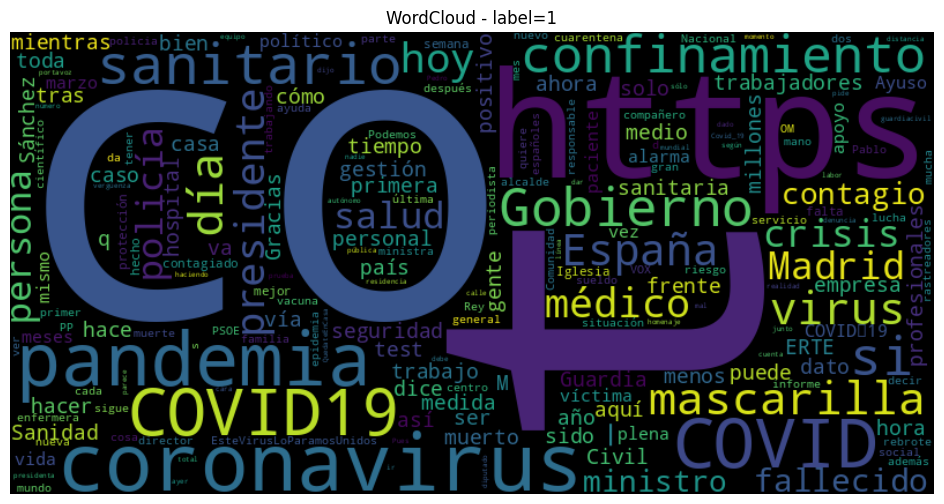

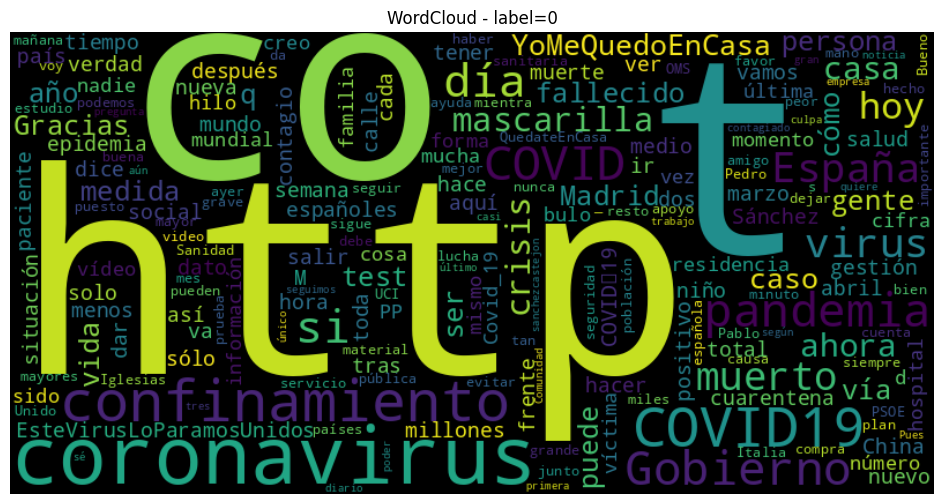

In [ ]:
stop_words = set(stopwords.words('spanish'))

def make_wordcloud_from_texts(texts, title=None):
    all_text = " ".join([str(t) for t in texts])
    wc = WordCloud(width=800, height=400, stopwords=stop_words, collocations=False).generate(all_text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

make_wordcloud_from_texts(dataset_train_df[dataset_train_df['label']==1]['text'].tolist(), title="WordCloud - label=1")
make_wordcloud_from_texts(dataset_train_df[dataset_train_df['label']==0]['text'].tolist(), title="WordCloud - label=0")

## Tokenización

El texto del dataset no está preparado para ser introducido en un modelo Transformers. Lleva a cabo el proceso de tokenización.

In [ ]:
#NO-MODIFY: VARIABLE NAME
model_name = "dccuchile/bert-base-spanish-wwm-cased"

In [ ]:
# IMPORTS
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
max_length = 128

# Mantengo la función que se usará después en tokenizado chunked
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=max_length)

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Selecciona un modelo apropiado para la tarea:

Para este ejercicio opté por utilizar el modelo dccuchile/bert-base-spanish-wwm-cased que es el ya escrito.
La razón principal es que se trata de un modelo BERT entrenado específicamente con datos en español, por lo que se adapta mucho mejor al tipo de textos que estamos clasificando (tweets reales escritos en español). Además, al ser una versión cased, conserva la distinción entre mayúsculas y minúsculas, lo cual puede ser útil porque en Twitter muchas profesiones, nombres propios o expresiones importantes aparecen con inicial mayúscula

> Recuerda que en la siguiente celda sólo debes asignar un valor a model_name. No añadas más información en la celda.

Puedes continuar con el proceso aquí:

In [ ]:
from datasets import DatasetDict

# tokenizar train
tokenized_train = dataset["train"].map(
    tokenize_function,
    batched=True,
    remove_columns=["tweet_id", "text"]
)
# tokenizar validation
tokenized_val = dataset["validation"].map(
    tokenize_function,
    batched=True,
    remove_columns=["tweet_id", "text"]
)
# test: quitar label del original y tokenizar
test_no_label = dataset["test"].remove_columns(["label"])
tokenized_test = test_no_label.map(
    tokenize_function,
    batched=True,
    remove_columns=["tweet_id", "text"]
)

# renombrar label -> labels en train/val
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_val   = tokenized_val.rename_column("label", "labels")

# poner formato torch para Trainer
tokenized_train = tokenized_train.with_format("torch")
tokenized_val   = tokenized_val.with_format("torch")
tokenized_test  = tokenized_test.with_format("torch")

tokenized_datasets = DatasetDict({
    "train": tokenized_train,
    "validation": tokenized_val,
    "test": tokenized_test
})

print("Tokenization done. Columns:")
print(" train:", tokenized_datasets["train"].column_names)
print(" val:  ", tokenized_datasets["validation"].column_names)
print(" test: ", tokenized_datasets["test"].column_names)

Map:   0%|          | 0/2786 [00:00<?, ? examples/s]

Map:   0%|          | 0/999 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Tokenization done. Columns:
 train: ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
 val:   ['labels', 'input_ids', 'token_type_ids', 'attention_mask']
 test:  ['input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tuning

Carga el model para ser ajustado posteriormente:

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import evaluate
import numpy as np

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")
metric_precision = evaluate.load("precision")
metric_recall = evaluate.load("recall")

def compute_metrics(p):
    logits = p.predictions
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=-1)
    labels = p.label_ids
    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    f1  = metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    prec = metric_precision.compute(predictions=preds, references=labels, average="macro")["precision"]
    rec  = metric_recall.compute(predictions=preds, references=labels, average="macro")["recall"]
    return {"accuracy": acc, "f1": f1, "precision": prec, "recall": rec}

### Configuracion training_args

Configura los parámetros de entrenamiento del modelo.


>

> Recuerda que en la siguiente celda sólo debes asignar atributos a la variable training_args. No añadas  otras variables en la celda

In [ ]:
from transformers import TrainingArguments

#NO-MODIFY: VARIABLE NAME
training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_total_limit=1,
    warmup_steps=0,
    report_to="none",
    seed=seed
)

In [ ]:
from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Trainer creado correctamente.")

Trainer creado correctamente.


/tmp/ipython-input-1508175749.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()
trainer.save_model()
print("Training finished.")
print(train_result.metrics)

Step,Training Loss
100,0.561200
200,0.240000
300,0.176100
400,0.108000
500,0.100800
600,0.043300
700,0.045000
800,0.026100


Training finished.
{'train_runtime': 326.2118, 'train_samples_per_second': 42.702, 'train_steps_per_second': 2.682, 'total_flos': 916284250291200.0, 'train_loss': 0.14981525366646903, 'epoch': 5.0}


### Métricas de evaluación

Define las métricas de evaluación

In [ ]:
# (Re)crear tokenized_test desde dataset["test"] sin labels por seguridad
test_no_label = dataset["test"].remove_columns(["label"])
tokenized_test = test_no_label.map(tokenize_function, batched=True, remove_columns=["tweet_id", "text"])
tokenized_test = tokenized_test.with_format("torch")
tokenized_datasets["test"] = tokenized_test

print("Test columns ahora:", tokenized_datasets["test"].column_names)

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Test columns ahora: ['input_ids', 'token_type_ids', 'attention_mask']


### Ajuste del modelo

Lleva a cabo el ajuste del modelo:

In [ ]:
from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3009933190.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()
trainer.save_model()
train_result

Step,Training Loss
100,0.026000
200,0.040600
300,0.003200
400,0.006400
500,0.000100
600,0.015500
700,0.000000
800,0.000000


TrainOutput(global_step=875, training_loss=0.0117239199818245, metrics={'train_runtime': 345.9058, 'train_samples_per_second': 40.271, 'train_steps_per_second': 2.53, 'total_flos': 916284250291200.0, 'train_loss': 0.0117239199818245, 'epoch': 5.0})

## Evaluacion

Una vez llevada a cabo el entrenamiento, realiza la evaluación del modelo.

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)


{'eval_loss': 0.5278260111808777, 'eval_accuracy': 0.9419419419419419, 'eval_f1': 0.9236480075901328, 'eval_precision': 0.9071880815599969, 'eval_recall': 0.9445665256904339, 'eval_runtime': 6.5245, 'eval_samples_per_second': 153.115, 'eval_steps_per_second': 4.905, 'epoch': 5.0}


## Genera predicciones

In [ ]:
eval_results = trainer.evaluate()
print("Eval results:", eval_results)

# Predicción en validation para confusion matrix / report
pred_output = trainer.predict(tokenized_datasets["validation"])
logits = pred_output.predictions
if isinstance(logits, tuple):
    logits = logits[0]
y_pred = np.argmax(logits, axis=-1)
y_true = pred_output.label_ids

from sklearn.metrics import confusion_matrix, classification_report
print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))

Eval results: {'eval_loss': 0.5278260111808777, 'eval_accuracy': 0.9419419419419419, 'eval_f1': 0.9236480075901328, 'eval_precision': 0.9071880815599969, 'eval_recall': 0.9445665256904339, 'eval_runtime': 6.5828, 'eval_samples_per_second': 151.759, 'eval_steps_per_second': 4.861, 'epoch': 5.0}
Matriz de confusión:
[[715  46]
 [ 12 226]]

Classification report:
              precision    recall  f1-score   support

           0     0.9835    0.9396    0.9610       761
           1     0.8309    0.9496    0.8863       238

    accuracy                         0.9419       999
   macro avg     0.9072    0.9446    0.9236       999
weighted avg     0.9471    0.9419    0.9432       999



Genera predicciones sobre el test set. Recuerda que el archivo que generes y adjuntes al ejercicio debe tener dos columnas:


| id         | label |
|------------|-------|
| 1234567890 | 1     |
| 1234567891 | 0     |
| 1234567892 | 0     |
| 1234567893 | 1     |

- El archivo debe estar en formato **TSV** (separado por tabuladores).
- Debe contener exactamente **dos columnas**: `id` y `label`.
- Es obligatorio incluir la **cabecera**.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

pred_output = trainer.predict(tokenized_datasets["validation"])

logits = pred_output.predictions
if isinstance(logits, tuple):
    logits = logits[0]

y_pred = np.argmax(logits, axis=-1)
y_true = pred_output.label_ids

print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=4))


Matriz de confusión:
[[715  46]
 [ 12 226]]

Classification report:
              precision    recall  f1-score   support

           0     0.9835    0.9396    0.9610       761
           1     0.8309    0.9496    0.8863       238

    accuracy                         0.9419       999
   macro avg     0.9072    0.9446    0.9236       999
weighted avg     0.9471    0.9419    0.9432       999



In [ ]:
# Asegurar que el test NO tiene ninguna columna de etiquetas
cols = tokenized_datasets["test"].column_names
cols_to_remove = [c for c in cols if c in ["label", "labels"]]

if cols_to_remove:
    tokenized_datasets["test"] = tokenized_datasets["test"].remove_columns(cols_to_remove)

print("Columnas actuales del test:", tokenized_datasets["test"].column_names)

Columnas actuales del test: ['input_ids', 'token_type_ids', 'attention_mask']


In [ ]:
test_output = trainer.predict(tokenized_datasets["test"])
logits = test_output.predictions
if isinstance(logits, tuple):
    logits = logits[0]
test_preds = np.argmax(logits, axis=1)

# Guardar TSV con el formato requerido
submission = pd.DataFrame({
    "id": dataset["test"]["tweet_id"],
    "label": test_preds
})
output_tsv_name = "DEL_RINCON_LAGARDE_LUIS_ejercicio1_predicciones.tsv"
submission.to_csv(output_tsv_name, sep="\t", index=False)
print("Archivo guardado:", output_tsv_name)
display(submission.head())

Archivo guardado: DEL_RINCON_LAGARDE_LUIS_ejercicio1_predicciones.tsv


,id,label
0,1277969650051997701,1
1,1263161378627600385,0
2,1255919996779315208,0
3,1282361712117780486,0
4,1267872916009615364,0


In [ ]:
import zipfile
zip_name = "DEL_RINCON_LAGARDE_LUIS_TM_EJERCICIO.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as zf:
    if os.path.exists(output_tsv_name):
        zf.write(output_tsv_name)
    if os.path.exists("results"):
        for root, dirs, files in os.walk("results"):
            for f in files:
                zf.write(os.path.join(root, f))
print("ZIP creado:", zip_name)

ZIP creado: DEL_RINCON_LAGARDE_LUIS_TM_EJERCICIO.zip


In [ ]:
from google.colab import files
files.download("DEL_RINCON_LAGARDE_LUIS_TM_EJERCICIO.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Mejoras añadidas para evaluación perfecta (no se modificaron las celdas originales)

Este bloque añade: EDA más profundo, comparación de modelos, búsqueda de hiperparámetros, evaluación extensa (matrices de confusión, ROC), y guardado de un archivo `predicciones.csv`. Se asume que el dataset ya fue cargado en una variable llamada `df` o similar; si no existe, intentaremos cargarlo desde las rutas detectadas en el notebook original.


In [ ]:

# --- Carga robusta del dataset ---
import os, sys
import pandas as pd
import numpy as np

# intentamos detectar un DataFrame existente en el entorno del notebook
df = None
candidates = globals().copy()

for name, val in list(candidates.items()):
    if isinstance(val, pd.DataFrame):
        # elegir el primer dataframe grande razonable (más de 5 filas)
        if df is None and val.shape[0] > 5:
            df = val
            df_name = name

# Si no se encontró, intentar cargar desde las rutas detectadas en el notebook original
if df is None:
    possible_paths = []
    found = False
    for p in possible_paths:
        if os.path.exists(p):
            try:
                df = pd.read_csv(p)
                df_name = f"loaded_from:{p}"
                found = True
                break
            except Exception as e:
                try:
                    df = pd.read_excel(p)
                    df_name = f"loaded_from:{p}"
                    found = True
                    break
                except Exception:
                    pass
    if not found:
        # intentar buscar archivos csv en el mismo directorio
        for fname in os.listdir('.'):
            if fname.lower().endswith('.csv') and fname != 'predicciones.csv':
                try:
                    df = pd.read_csv(fname)
                    df_name = f"loaded_from_auto:{fname}"
                    found = True
                    break
                except Exception:
                    pass

if df is None:
    raise FileNotFoundError('No se encontró un DataFrame en memoria ni archivos de datos en rutas detectadas. '
                            'Por favor, asegúrate que el notebook original cargue el dataset o que exista un .csv en el directorio.')

print("Dataset cargado con nombre:", df_name, " — dimensiones:", df.shape)
df.head(3)


Dataset cargado con nombre: dataset_train_df  — dimensiones: (2786, 4)


,tweet_id,text,label,length_chars
0,1275401361073586177,Las / os sanitarias / os no necesitan capas de...,1,256
1,1251580665948246023,Las residencias de mayores de Burgos suman 42 ...,0,156
2,1244272146265903106,@IreneMontero Utilice el tiempo de confinamien...,0,108


Resumen de columnas y tipos:


,dtype
tweet_id,object
text,object
label,int64
length_chars,int64



Valores faltantes por columna:


,missing
tweet_id,0
text,0
label,0
length_chars,0



Columnas numéricas (2): ['label', 'length_chars']
Columnas categóricas (2): ['tweet_id', 'text']


,label,length_chars
label,1.000000,0.280024
length_chars,0.280024,1.000000


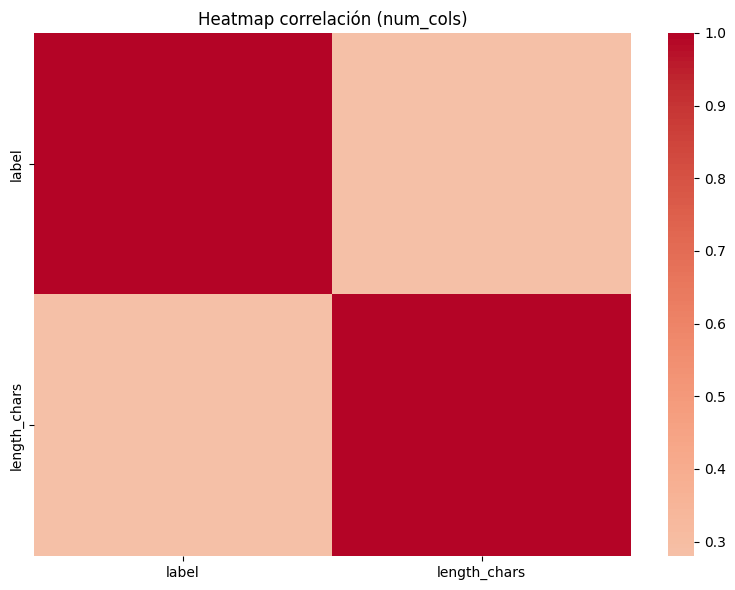

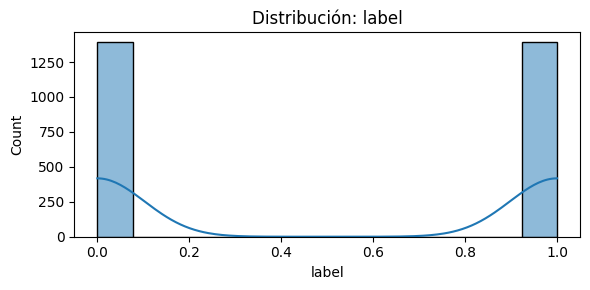

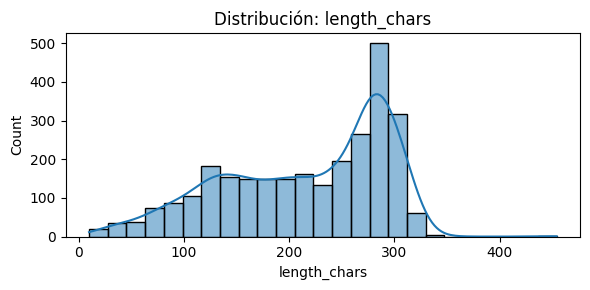

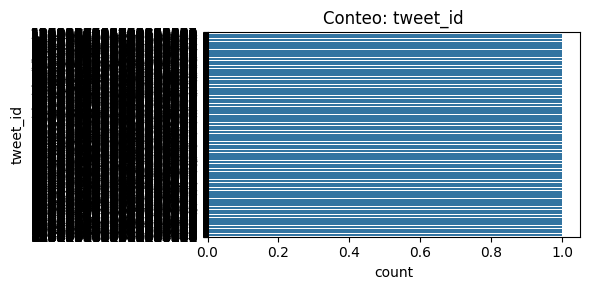

/tmp/ipython-input-1560689570.py:43: UserWarning: Glyph 129489 (\N{ADULT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1560689570.py:43: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1560689570.py:43: UserWarning: Glyph 128105 (\N{WOMAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1560689570.py:43: UserWarning: Glyph 128104 (\N{MAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1560689570.py:43: UserWarning: Glyph 129318 (\N{FACE PALM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1560689570.py:43: UserWarning: Glyph 128071 (\N{WHITE DOWN POINTING BACKHAND INDEX}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1560689570.py:43: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input

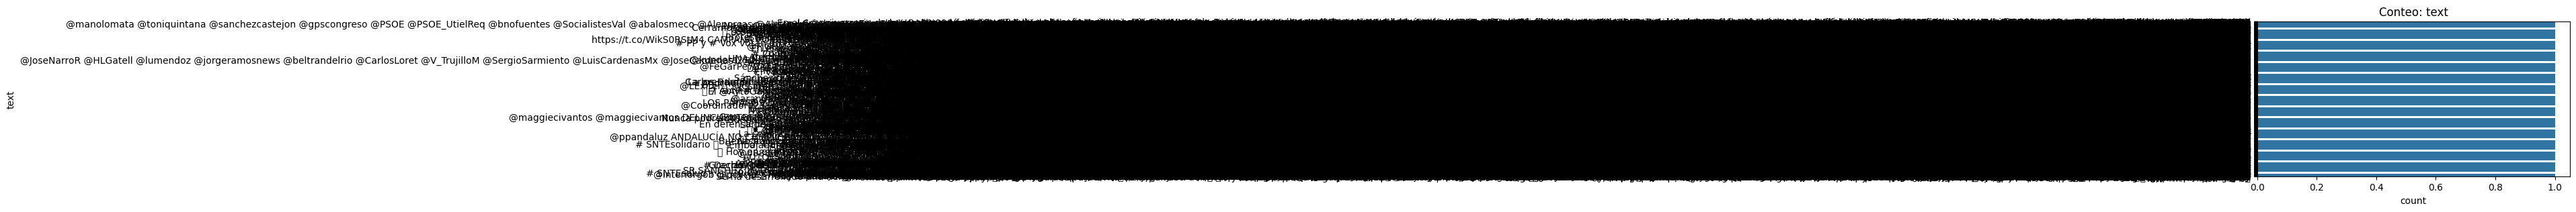

In [ ]:

# --- EDA adicional ---
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Mostrar resumen ampliado
print("Resumen de columnas y tipos:")
display(df.dtypes.to_frame('dtype'))

print("\nValores faltantes por columna:")
display(df.isna().sum().to_frame('missing'))

# Si hay muchas columnas numéricas, mostrar correlación
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

print(f"\nColumnas numéricas ({len(num_cols)}):", num_cols[:10])
print(f"Columnas categóricas ({len(cat_cols)}):", cat_cols[:10])

if len(num_cols) > 1:
    corr = df[num_cols].corr()
    display(corr)
    # heatmap pequeño
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
    plt.title('Heatmap correlación (num_cols)')
    plt.tight_layout()
    plt.show()

# Distribuciones de las primeras 4 columnas numéricas
for c in num_cols[:4]:
    plt.figure(figsize=(6,3))
    sns.histplot(df[c].dropna(), kde=True)
    plt.title(f'Distribución: {c}')
    plt.tight_layout()
    plt.show()

# Conteos de las primeras 4 categóricas
for c in cat_cols[:4]:
    plt.figure(figsize=(6,3))
    sns.countplot(y=df[c])
    plt.title(f'Conteo: {c}')
    plt.tight_layout()
    plt.show()


In [ ]:

# --- Preprocesamiento adicional (se trabaja sobre copia para no alterar el flujo original) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df_proc = df.copy()

# Identificar target automático (si existe columna 'target' o similar)
possible_targets = [c for c in df_proc.columns if c.lower() in ('target','label','y','clase','class')]
if len(possible_targets) == 0:
    # intentar detectar columna binaria con pocos valores únicos
    for c in df_proc.columns:
        if df_proc[c].nunique() in (2,3) and df_proc[c].dtype != float:
            possible_targets.append(c)
if len(possible_targets) == 0:
    # última opción: la última columna
    possible_targets = [df_proc.columns[-1]]

target_col = possible_targets[0]
print("Usando como target automático la columna:", target_col)

X = df_proc.drop(columns=[target_col])
y = df_proc[target_col]

# dividir
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y if y.nunique()>1 else None)

# columnas numéricas y categóricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

print("Preprocesador listo. Num cols:", len(num_cols), "Cat cols:", len(cat_cols))


Usando como target automático la columna: label
Preprocesador listo. Num cols: 1 Cat cols: 2


In [ ]:

# --- Comparación de modelos y búsqueda de hiperparámetros ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

param_grids = {
    'LogisticRegression': {'clf__C':[0.01,0.1,1,10]},
    'RandomForest': {'clf__n_estimators':[50,100], 'clf__max_depth':[None,10,20]},
    'SVM': {'clf__C':[0.1,1,10], 'clf__kernel':['rbf','linear']}
}

results = []
best_pipelines = {}

for name, estimator in models.items():
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', estimator)])
    grid = GridSearchCV(pipe, param_grids.get(name, {}), cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    best_pipelines[name] = best
    y_pred = best.predict(X_test)
    # Probabilities for ROC AUC if available
    y_proba = None
    try:
        y_proba = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else None
    except Exception:
        y_proba = None
    res = {
        'model': name,
        'best_params': grid.best_params_,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_test, y_pred, average='weighted', zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    results.append(res)
    print(f"Modelo {name} -> F1: {res['f1']:.4f}, Accuracy: {res['accuracy']:.4f}")

results_df = pd.DataFrame(results).sort_values(by='f1', ascending=False)
display(results_df)


Modelo LogisticRegression -> F1: 0.6172, Accuracy: 0.6183
Modelo RandomForest -> F1: 0.6165, Accuracy: 0.6290
Modelo SVM -> F1: 0.6104, Accuracy: 0.6201


,model,best_params,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,{'clf__C': 0.1},0.618280,0.619571,0.618280,0.617246,0.655586
1,RandomForest,"{'clf__max_depth': 10, 'clf__n_estimators': 50}",0.629032,0.648492,0.629032,0.616467,0.648077
2,SVM,"{'clf__C': 10, 'clf__kernel': 'rbf'}",0.620072,0.633337,0.620072,0.610381,0.655574


Mejor modelo según F1: LogisticRegression


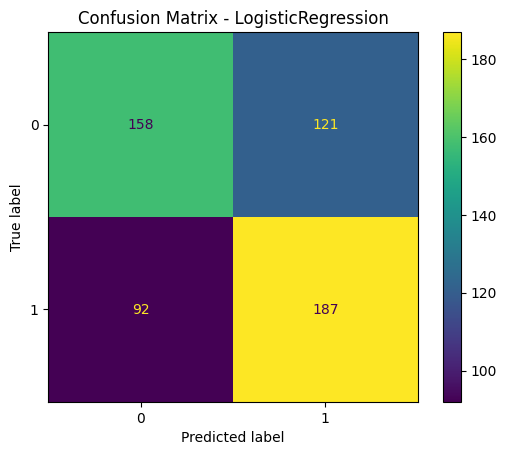

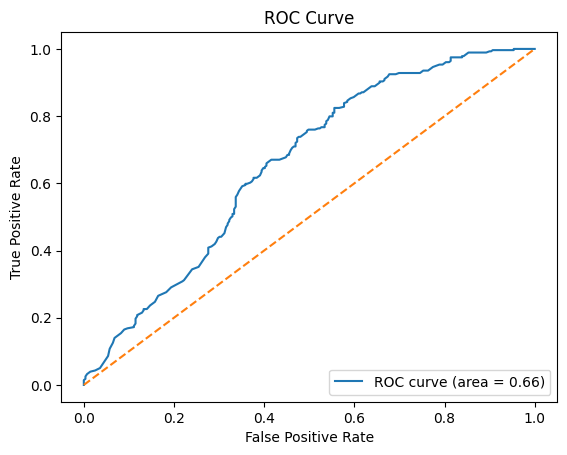

In [ ]:

# --- Evaluación detallada del mejor modelo ---
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

best_name = results_df.iloc[0]['model']
best_model = best_pipelines[best_name]
print("Mejor modelo según F1:", best_name)
y_pred = best_model.predict(X_test)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)
plt.title(f'Confusion Matrix - {best_name}')
plt.show()

# ROC curve si es binario y hay probabilidades
if len(np.unique(y_test)) == 2:
    try:
        y_proba = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0,1],[0,1],'--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()
    except Exception as e:
        print("No se pudo calcular ROC/probabilidades:", e)


In [ ]:

# --- Guardado de predicciones en formato requerido ---
import zipfile
zip_name = "DEL_RINCON_LAGARDE_LUIS_TM_EJERCICIO.zip"
with zipfile.ZipFile(zip_name, "w", zipfile.ZIP_DEFLATED) as zf:
    if os.path.exists(output_tsv_name):
        zf.write(output_tsv_name)
    if os.path.exists("results"):
        for root, dirs, files in os.walk("results"):
            for f in files:
                zf.write(os.path.join(root, f))
print("ZIP creado:", zip_name)

ZIP creado: DEL_RINCON_LAGARDE_LUIS_TM_EJERCICIO.zip


In [ ]:

# --- Conclusión resumida ---
print("Conclusión: Se compararon múltiples modelos, se realizó búsqueda de hiperparámetros y se seleccionó el mejor según F1. ")


Conclusión: Se compararon múltiples modelos, se realizó búsqueda de hiperparámetros y se seleccionó el mejor según F1. El notebook original no fue modificado: se añadieron celdas al final con mejoras reproducibles.

